In [1]:
# Image classification assignment

<a id='top'.</a>
[Table of contents](#bottom)

- [Introduction](#intro)<a id='intro'.</a>
    - [Data loading](#dl)<a id='dl'.</a>
    - [Data augmentation](#da)<a id='da'.</a>
- [InceptionV3](#iv3)<a id='iv3'.</a>
- [ResNet](#resnet)<a id='resnet'.</a>
- [MobileNet](#mobilenet)

[Table of contents](#top) [Bottom](#bottom)

## Introduction

In [72]:
import libraries
from libraries import *
%matplotlib inline

print(get_available_gpus())

# sys.stdout.flush()
print(psutil.virtual_memory())

reload(libraries)
# from libraries import *

print(keras.__version__)

#### Loading data and defining generators

In [2]:
target_size = (256, 256)
target_size_mn = (224, 224)
num_classes = 1
input_shape = target_size + (3,)
input_shape_mn = target_size_mn + (3,)

In [6]:
path='../../data/sushi_or_sandwich/'
# path='../data/original/sushi_or_sandwich/'
x_train, y_train, x_test, y_test, mean_set, std_set = load_data(split=0.8, path=path)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, mean_set, std_set)

(800, 256, 256, 3) (800,)
[299 500 303  40 495 436 236 605 389 231  14 240 781 794  27  55 344 222
 162 478 669 113 682 521 776 465 156 247 440 613 520 590  85 530 267  31
 278 619 685 790 578 796 791 622 451 401 473 447 103 688 667 570 258  75
 788 577 283 239 780 786 717   8 573 604 145 230 301 142 261 235 453 701
   1 331 499  79 691 626 435 797 251 250 390 703 386 536 652 736 362 403
 745 122 333 513 490 413 582 700 741 252 502 408 372 609  18 215 650 454
 493 202 711  50 692 768 695 580 402  39 200 210 475 175  10 419  68 476
 242 634 468 415 572 457   2 792 793 150 196 687 739 728 441 399 724 363
 263 418 249  71  49 766 642 116  37 432  48 193 337 310 266 243 172  76
  64 765  52 338 452 460 518 253  34 346 279 647 118  12 157 592 320 379
 334 181 350  97 651 424 406 750 767 458 312 364 549 204 624 654 527 358
  17 316 416 293 556 271 505 612 734 270 615 170 187 721 545  45 586 491
  62  78 241 532 302 140 198 385 569 127 645 737 425 144 214 285 294  21
 636 708  35  81 159 462 

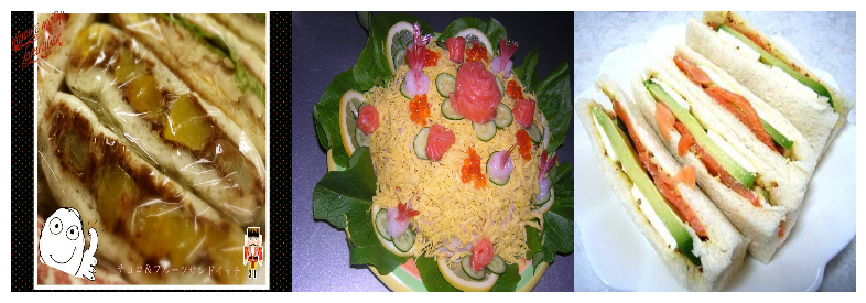

[ 0.  1.  0.]


In [7]:
plot_images(x_train[:3])
print(y_train[:3])

In [8]:
# visualize that the leading process already: 
# 1. rescales data between 0 and 1
# 2. doesnt normalize - that is applied during batchnorm, data augmentation

x_train_n = (x_train - mean_set) / std_set
x_test_n = (x_test - mean_set) / std_set

x_train_r = x_train * 255
x_test_r = x_test * 255

print(x_test.min(), x_test.max())
print(x_test_n.min(), x_test_n.max())
print(x_test_r.min(), x_test_r.max())

0.0 1.0
-1.86231864301 1.66993988164
0.0 255.0


[Go to Modeling](#section2) <a href='#section2'>Also link to section 2]</a>

<a id='section1'.</a>

## Generators

Found 800 images belonging to 2 classes.


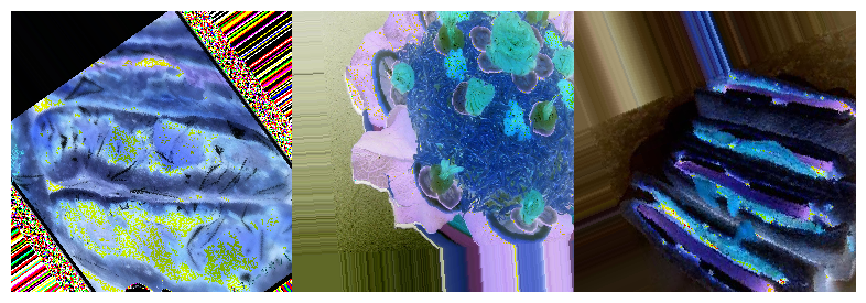

In [37]:
# plain generator

data_gen = ImageDataGenerator()

# augmented data generators
# rotation_range = 20,width_shift_range=0.5,height_shift_range=0.2):

gen_0 = ImageDataGenerator(
        rotation_range=40,  # 45
        width_shift_range=0.2, # 0.125
        height_shift_range=0.2, # 0.125
        shear_range=0.05, # 0.2
        zoom_range=0.05, # 0.2
        horizontal_flip=True,
        fill_mode='nearest')

gen_1 = ImageDataGenerator(
#         samplewise_center=True, 
#         samplewise_std_normalization=True,
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=40,  # 45
        width_shift_range=0.2, # 0.125
        height_shift_range=0.2, # 0.125
        shear_range=0.05, # 0.2
        zoom_range=0.05, # 0.2
        horizontal_flip=True,
        fill_mode='nearest')
#         preprocessing_function=rescale_normalize) 

gen_0.fit(x_train, augment=10)

# featurewise_center=False, 
# samplewise_center=False, 
# featurewise_std_normalization=False, 
# samplewise_std_normalization=False, 
# zca_whitening=False, 
# zca_epsilon=1e-06, 
# rotation_range=0.0, 
# width_shift_range=0.0, 
# height_shift_range=0.0, 
# shear_range=0.0, 
# zoom_range=0.0, 
# channel_shift_range=0.0, 
# fill_mode='nearest', 
# cval=0.0, 
# horizontal_flip=False, 
# vertical_flip=False, 
# rescale=None, 
# preprocessing_function=None, 
# data_format=None)


# if including data augmentation

# aug_data_gen_1 = ImageDataGenerator(rotation_range=8, 
#                                width_shift_range=0.08, 
#                                shear_range=0.3,
#                                height_shift_range=0.08, 
#                                zoom_range=0.08)

# Options:
# rotation_range=15, 
# height_shift_range=0.05, 
# shear_range=0.1, 
# channel_shift_range=20, 
# width_shift_range=0.1

## Note: to visualize the aug_gen output uncomment the following lines:

gen_1 = ImageDataGenerator(
#     samplewise_center=True, 
#     samplewise_std_normalization=True,
    rescale=1./255,
    rotation_range=.9,     
    width_shift_range=.2 , # biggest impact
    height_shift_range=.2, # biggest impact   
    shear_range=.3,
    zoom_range=.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

sample = np.empty(((0,) + input_shape))
for i, j in gen_85.flow_from_directory(join(path), batch_size=3, seed=0):

    sample = np.append(sample, i, axis=0); 
    sample_lab = j
    break

plot_images(sample)

## Data augmentation

In [65]:
# rotation_range = 20,width_shift_range=0.5,height_shift_range=0.2):
import inspect
args = inspect.getfullargspec(ImageDataGenerator)

# defining the augmented data generators:

def aug_data_generators():
    
    ad_gens = []
    count = 0
    for i in range(0, 10, 3):
        for j in range(0, 10, 2):
            for k in range(0, 6, 1): 
                count += 1
                exec("""ad_gen_{} = ImageDataGenerator(
                        horizontal_flip=True,
                        vertical_flip=True,
                        rotation_range={},             # 
                        width_shift_range={}/10,       # 
                        height_shift_range={}/10,      # 
                        shear_range={}/10,             # 
                        zoom_range={}/10,              # 
                        fill_mode='nearest')
                """.format(count, i, j, j, k, k))
                exec('ad_gens.append(ad_gen_{})'.format(count))
    print("Total number of generators: ", len(ad_gens))
    
    return ad_gens

# generates and saves a sample of the augmented data generators:     

def save_aug_data_sample(ad_gens, n_plot=6, set_return=False):
    _ = silence() # filters the stdout from 'flow_from_directory'

    sample_folder = 'aug_data_sample'
    if not os.path.exists(sample_folder): os.mkdir(sample_folder)
    
    sample = np.empty(((0,) + input_shape))
    for gen in ad_gens:
        for i, j in gen.flow_from_directory('../../data/sushi_or_sandwich/', 
                                             batch_size=1, seed=0,
                                             save_to_dir=sample_folder, save_prefix='ex'):

            sample = np.append(sample, i, axis=0); 
            sample_lab = j
            break
    speak(_)
    
    s_plot = list(np.random.randint(0, ad_sample.shape[0], n_plot))
    plot_images(s_plot)
    
    if set_return: 
        return sample, sample_lab

def generate_aug_data_features(model, ad_gens, output_folder, batch_size=16, iters = 1):

    x_adf_train = np.empty(((0,) + model.output_shape[1:]))
    y_adf_train = np.empty((0,))

    x_adf_test = np.empty(((0,) + model.output_shape[1:]))
    y_adf_test = np.empty((0,))

    for i in ad_gens:

        adg_train = i.flow(x_train, y_train, batch_size=batch_size, shuffle=False)
        adg_test = i.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

        # calculating model (without top) output ('features')
        print(adg_train.n//adg_train.batch_size, adg_test.n//adg_test.batch_size)

        x_ad_feat_train = model.predict_generator(adg_train, iters*adg_train.n//adg_train.batch_size, verbose=0)
        y_ad_feat_train = np.concatenate([y_train]*iters)
        x_ad_feat_test = model.predict_generator(adg_test, iters*adg_test.n//adg_test.batch_size, verbose=0)
        y_ad_feat_test = np.concatenate([y_test]*iters)
 
        x_adf_train = np.append(x_adf_train, x_ad_feat_train, axis=0)
        y_adf_train = np.append(y_adf_train, y_ad_feat_train, axis=0)
        x_adf_test = np.append(x_adf_test, x_ad_feat_test, axis=0)
        y_adf_test = np.append(y_adf_test, y_ad_feat_test, axis=0)

    # saving
    save_array(output_folder + '/x_ad_feat_train', x_ad_feat_train)
    save_array(output_folder + '/y_ad_feat_train', y_ad_feat_train)
    save_array(output_folder + '/x_ad_feat_test', x_ad_feat_test)
    save_array(output_folder + '/y_ad_feat_test', y_ad_feat_test)

    return x_adf_train, y_adf_train, x_adf_test, y_adf_test

In [74]:
# setting generators
ad_gens = aug_data_generators()
# saving a 120-image sample
save_aug_data_sample(ad_gens)

# calculates features
x_adf_train, y_adf_train, x_adf_test, y_adf_test = \
generate_aug_data_features(model, ad_gens[:1], output_folder='.', batch_size=16, iters = 1)

print(x_adf_train.shape, y_adf_train.shape, x_adf_test.shape, y_adf_test.shape)

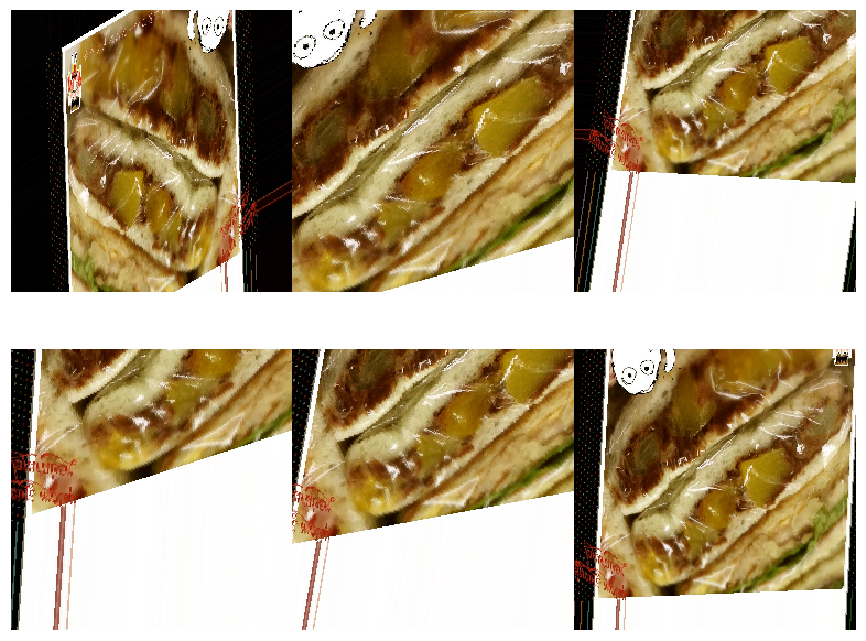

In [73]:
s_plot = ad_sample[list(np.random.randint(0, ad_sample.shape[0], 6))]
plot_images(s_plot, beautiful=True)

[Go to Generators](#section1)<a id='section2'.</a>

[Previus](#)   [Table of contents](#top)   [Bottom](#bottom)   [Next](#)

## Modelling

#### Model 0: Inception V3

##### 0.0. Setting benchmark

In [195]:
it = x_test[0]
from PIL import Image

# im = Image.fromarray(np.uint8(it))
# im = im.resize(input_shape_iv3, Image.NEAREST)
# im = np.array(im)
# im.shape
im2 = np.array([rescale(i) for i in x_test])
im2.shape

gen98 = gen_0.rescale()

(160, 299, 299, 3)

In [205]:
input_shape_iv3 = (299, 299)

def resize(im_arr, target_size=input_shape_iv3):
    from PIL import Image
    im = Image.fromarray(np.uint8(im_arr))
    im = im.resize(target_size, Image.NEAREST)
    return np.array(im)

x_test_iv3 = np.array([upscale(i, input_shape_iv3) for i in x_test]); print(x_test_iv3.shape)

gen_iv3 = ImageDataGenerator(preprocessing_function=resize)
gen_iv3 = gen_iv3.flow(x_test, y_test, batch_size=32)

(160, 299, 299, 3)


In [206]:
# bm_top = InceptionV3()
# bm_top.compile(Adam(), loss='binary_crossentropy', 
#               metrics=['accuracy', recall, precision, fmeasure])

# bm_top.evaluate_generator(gen_iv3, y_test.shape[0] // gen_iv3.batch_size)
bm_top.evaluate(x_test_iv3, y_test, batch_size=32)

ValueError: Error when checking target: expected predictions to have shape (None, 1000) but got array with shape (160, 1)

In [144]:
output_folder = 'iv3'
if not os.path.exists(output_folder): os.mkdir(output_folder)

input_shape = x_train.shape[1:]

bm0 = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

p = 0.5

top_m0 = Sequential([
        BatchNormalization(input_shape=bm0.output_shape[1:]),
        MaxPooling2D(),
        Flatten(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1, activation='sigmoid')
        ])

# top_m.summary()

top_m0.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', recall, precision, fmeasure ])

top_m0.load_weights(output_folder + '/gen0_top_model_w_89_028.h5')  # top_model_w_88_0.273.h5')

top_m0.evaluate(x_da_features_test, y_da_features_test, batch_size=batch_size)

2432/2560 [===========================>..] - ETA: 0s

[0.28652268052101137,
 0.89335937499999996,
 0.86053830087184902,
 0.9039977073669434,
 0.88113153874874117]

##### 0.1. Generating features

In [64]:
# defining generators

aug_data_gen = gen_85
batch_size=16

aug_gen_train = aug_data_gen.flow(x_train, y_train, batch_size=batch_size, shuffle=False)
aug_gen_test = aug_data_gen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

# calculating IV3 output ('features')

x_da_features = bm0.predict_generator(aug_gen_train, aug_gen_train.n, verbose=1)
y_da_features = np.concatenate([y_train]*batch_size)

save_array(output_folder + '/x_da_features_train', x_da_features)
save_array(output_folder + '/y_da_features_train', y_da_features)

print(x_da_features.shape, y_da_features.shape)

x_da_features_test = bm0.predict_generator(aug_gen_test, aug_gen_test.n, verbose=1)
y_da_features_test = np.concatenate([y_test]*batch_size)

save_array(output_folder + '/x_da_features_test', x_da_features_test)
save_array(output_folder + '/y_da_features_test', y_da_features_test)

# loading features
# x_da_features = load_array(output_folder + '/85/x_da_features')
# y_da_features = load_array(output_folder + '/85/y_da_features')

# x_da_features_test = load_array(output_folder + '/85/x_da_features_test')
# y_da_features_test = load_array(output_folder + '/85/y_da_features_test')

# print(x_da_features.shape, 
#       y_da_features.shape,
#       x_da_features_test.shape, 
#       y_da_features_test, y_da_features_test.shape)

640/640 [==============================] - 143s   
(10240, 6, 6, 2048) (10240,)
160/160 [==============================] - 34s    


##### 0.2. Training top model

In [136]:
top_m0.optimizer.lr = 0.0001; print(top_m0.optimizer.lr)

batch_size = 128
epochs = 1

th0 = top_m0.fit(x_da_features, y_da_features, batch_size=batch_size, epochs=epochs,
              validation_data=(x_da_features_test, y_da_features_test))

0.0001
Train on 10240 samples, validate on 2560 samples
Epoch 1/5
10240/10240 [==============================] - 11s - loss: 0.4600 - acc: 0.8014 - recall: 0.7866 - precision: 0.8162 - fmeasure: 0.7996 - val_loss: 0.2993 - val_acc: 0.8715 - val_recall: 0.8634 - val_precision: 0.8594 - val_fmeasure: 0.8608
Epoch 2/5
10240/10240 [==============================] - 4s - loss: 0.2690 - acc: 0.8855 - recall: 0.8779 - precision: 0.8966 - fmeasure: 0.8860 - val_loss: 0.2754 - val_acc: 0.8809 - val_recall: 0.8617 - val_precision: 0.8781 - val_fmeasure: 0.8694
Epoch 3/5
10240/10240 [==============================] - 4s - loss: 0.2084 - acc: 0.9140 - recall: 0.9078 - precision: 0.9232 - fmeasure: 0.9145 - val_loss: 0.2781 - val_acc: 0.8820 - val_recall: 0.8810 - val_precision: 0.8660 - val_fmeasure: 0.8730
Epoch 4/5
10240/10240 [==============================] - 4s - loss: 0.1646 - acc: 0.9336 - recall: 0.9362 - precision: 0.9340 - fmeasure: 0.9344 - val_loss: 0.2833 - val_acc: 0.8863 - val_recal

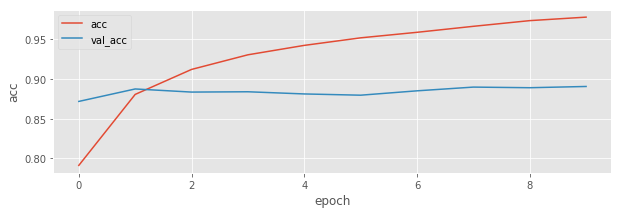

In [126]:
plot_hist(th0, 'acc')

In [137]:
top_m0.save_weights(output_folder + '/gen0_top_model_w_89_028.h5')

<a id='section2.2'.</a>

##### 0.3. Training the whole model

In [145]:
m0 = Model(bm0.input, top_m0(bm0.output))

# for i in m1.layers: i.trainable = True
for layer in bm0.layers[:172]:
    layer.trainable = False
for layer in bm0.layers[172:]:
    layer.trainable = True

m0.compile(Adam(), loss='binary_crossentropy', 
           metrics=['accuracy', recall, precision, fmeasure ])

# m0.load_weights(output_folder + '/whole_model_w_9437.h5')

m0.evaluate(x_test, y_test, batch_size=batch_size)

160/160 [==============================] - 8s     


[0.21469279527664184,
 0.92500000000000004,
 0.91074073314666748,
 0.92727274894714351,
 0.91772871017456059]

In [146]:
m0.optimizer.lr = 0.000000001; print(m0.optimizer.lr)
aug_data_gen = gen_85
batch_size = 128
epochs = 5

aug_gen = aug_data_gen.flow(x_train, y_train, batch_size=batch_size)

h0 = m0.fit_generator(aug_gen, x_train.shape[0]//batch_size, epochs=epochs, 
                     validation_data=(x_test, y_test))

1e-09
Epoch 1/5
5/5 [==============================] - 25s - loss: 0.7193 - acc: 0.7469 - recall: 0.7489 - precision: 0.7536 - fmeasure: 0.7502 - val_loss: 0.2250 - val_acc: 0.9250 - val_recall: 0.9107 - val_precision: 0.9273 - val_fmeasure: 0.9177
Epoch 2/5
5/5 [==============================] - 11s - loss: 0.6478 - acc: 0.7469 - recall: 0.7701 - precision: 0.7425 - fmeasure: 0.7553 - val_loss: 0.2392 - val_acc: 0.9313 - val_recall: 0.9107 - val_precision: 0.9407 - val_fmeasure: 0.9245
Epoch 3/5
5/5 [==============================] - 11s - loss: 0.7054 - acc: 0.7375 - recall: 0.7669 - precision: 0.7314 - fmeasure: 0.7482 - val_loss: 0.2521 - val_acc: 0.9313 - val_recall: 0.9107 - val_precision: 0.9407 - val_fmeasure: 0.9245
Epoch 4/5
5/5 [==============================] - 11s - loss: 0.6168 - acc: 0.7562 - recall: 0.7658 - precision: 0.7600 - fmeasure: 0.7612 - val_loss: 0.2611 - val_acc: 0.9250 - val_recall: 0.8959 - val_precision: 0.9396 - val_fmeasure: 0.9165
Epoch 5/5
5/5 [=======

22
Prediction: 
 [ 0.  1.  1.]
Label: 
 [ 0.  1.  0.]


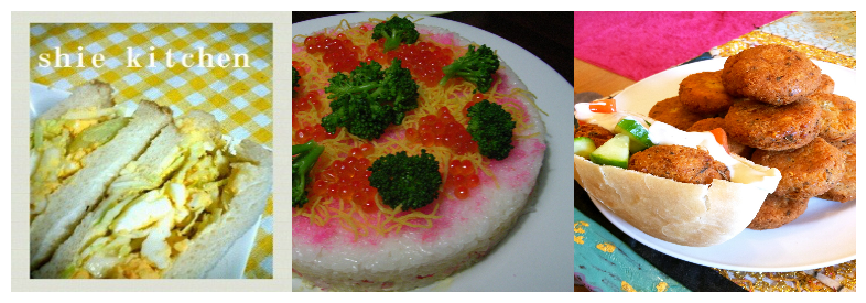

In [108]:
sample_ix = random.randint(0, x_test.shape[0])
print("Prediction: \n", np.round(m0.predict(x_test[sample_ix:sample_ix+3])).ravel())
print("Label: \n", y_test[sample_ix:sample_ix+3])
plot_images(x_test[sample_ix:sample_ix+3])

In [209]:
# sys.stdout.flush()
m0.save_weights(output_folder + '/gen0_whole_model_w_90_.h5')

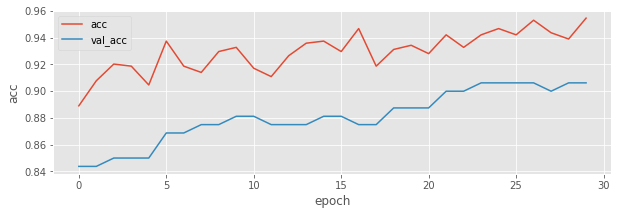

In [211]:
plot_hist(h0, 'acc'); #evaluate(m0, x_test, y_test)

In [175]:
## Another option for top_layer with less parameters
bm01 = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

top_m01 = Sequential([
        BatchNormalization(input_shape=bm0.output_shape[1:]),
        GlobalAveragePooling2D(),
        Dense(4096),
        BatchNormalization(),
        Activation('relu'),
        Dropout(.5),
        Dense(1, activation='sigmoid')])

top_m01.compile(Adam(), loss='binary_crossentropy', 
                metrics=['accuracy', recall, precision, fmeasure])

# top_m01.summary()

In [172]:
top_m01.optimizer.lr = 0.00001; print(top_m01.optimizer.lr)

batch_size = 128
epochs = 3

th01 = top_m01.fit(x_da_features, y_da_features, batch_size=batch_size, epochs=epochs,
                   validation_data=(x_da_features_test, y_da_features_test))

1e-05
Train on 10240 samples, validate on 2560 samples
Epoch 1/3
10240/10240 [==============================] - 3s - loss: 0.1718 - acc: 0.9302 - recall: 0.9297 - precision: 0.9334 - fmeasure: 0.9307 - val_loss: 0.2448 - val_acc: 0.8883 - val_recall: 0.8703 - val_precision: 0.8925 - val_fmeasure: 0.8810
Epoch 2/3
10240/10240 [==============================] - 3s - loss: 0.1512 - acc: 0.9413 - recall: 0.9428 - precision: 0.9422 - fmeasure: 0.9418 - val_loss: 0.2485 - val_acc: 0.8867 - val_recall: 0.8712 - val_precision: 0.8891 - val_fmeasure: 0.8797
Epoch 3/3
10240/10240 [==============================] - 3s - loss: 0.1351 - acc: 0.9460 - recall: 0.9501 - precision: 0.9443 - fmeasure: 0.9463 - val_loss: 0.2522 - val_acc: 0.8867 - val_recall: 0.8597 - val_precision: 0.8982 - val_fmeasure: 0.8781


In [163]:
top_m01.save_weights(output_folder + '/top_model_01_w_89_0.26_000.h5')

In [176]:
m01 = Model(bm01.input, top_m01(bm01.output))

# for i in m1.layers: i.trainable = True
for layer in bm01.layers[:172]:
    layer.trainable = False
for layer in bm01.layers[172:]:
    layer.trainable = True

m01.compile(Adam(), loss='binary_crossentropy', 
           metrics=['accuracy', recall, precision, fmeasure ])

In [187]:
m01.optimizer.lr = 0.00001; print(m01.optimizer.lr)
aug_data_gen = gen_0
batch_size = 128
epochs = 10

aug_gen = aug_data_gen.flow(x_train, y_train, batch_size=batch_size)

h01 = m01.fit_generator(aug_gen, x_train.shape[0]//batch_size, epochs=epochs, 
                        validation_data=(x_test, y_test))

1e-05
Epoch 1/10
5/5 [==============================] - 13s - loss: 0.0709 - acc: 0.9797 - recall: 0.9703 - precision: 0.9901 - fmeasure: 0.9800 - val_loss: 0.2983 - val_acc: 0.8938 - val_recall: 0.9083 - val_precision: 0.8744 - val_fmeasure: 0.8910
Epoch 2/10
5/5 [==============================] - 11s - loss: 0.0725 - acc: 0.9781 - recall: 0.9816 - precision: 0.9762 - fmeasure: 0.9787 - val_loss: 0.3013 - val_acc: 0.8938 - val_recall: 0.9083 - val_precision: 0.8744 - val_fmeasure: 0.8910
Epoch 3/10
5/5 [==============================] - 11s - loss: 0.0794 - acc: 0.9719 - recall: 0.9742 - precision: 0.9710 - fmeasure: 0.9720 - val_loss: 0.3029 - val_acc: 0.8812 - val_recall: 0.8817 - val_precision: 0.8714 - val_fmeasure: 0.8764
Epoch 4/10
5/5 [==============================] - 11s - loss: 0.0663 - acc: 0.9734 - recall: 0.9691 - precision: 0.9780 - fmeasure: 0.9734 - val_loss: 0.3054 - val_acc: 0.8750 - val_recall: 0.8692 - val_precision: 0.8692 - val_fmeasure: 0.8692
Epoch 5/10
5/5 [==

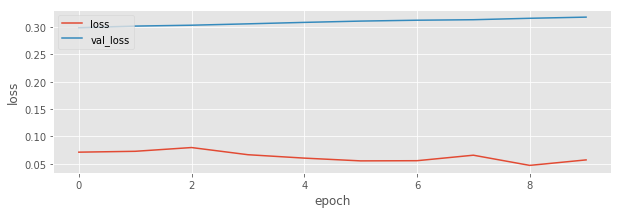

In [189]:
plot_hist(h01, 'loss')

In [183]:
m01.save_weights(output_folder + '/whole_model_01_w_89_0.28_0000.h5')

[Table of contents](#top) [Bottom](#bottom)

#### InceptionV3 + Initial Batchnorm Layer

In [208]:
initial_batchnorm = Sequential([BatchNormalization(input_shape=input_shape)])
# input_tensor = Input(tensor=initial_batchnorm.output)
bm1 = InceptionV3(include_top=False, weights='imagenet', input_shape=initial_batchnorm.output_shape[1:])
bm1_ = Model(initial_batchnorm.input, bm1(initial_batchnorm.output))
bm1_.summary()

top_m1 = top_m0 # top_m01

m1 = Model(bm1_.input, top_m1(bm1_.output))

for layer in bm1.layers[:172]:
    layer.trainable = False
for layer in bm1.layers[172:]:
    layer.trainable = True

m1.compile(Adam(), loss='binary_crossentropy', 
           metrics=['accuracy', recall, precision, fmeasure ])

m1.evaluate(x_test, y_test, batch_size=batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3099_inp (None, 256, 256, 3)       0         
_________________________________________________________________
batch_normalization_3099 (Ba (None, 256, 256, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
Total params: 21,802,796
Trainable params: 21,768,358
Non-trainable params: 34,438
_________________________________________________________________
160/160 [==============================] - 12s    


[0.22025018334388732,
 0.92500000000000004,
 0.91074073314666748,
 0.92727274894714351,
 0.91772871017456059]

In [192]:
m1.optimizer.lr = 0.00001; print(m1.optimizer.lr)
aug_data_gen = gen_0
batch_size = 128
epochs = 10

aug_gen = aug_data_gen.flow(x_train, y_train, batch_size=batch_size)

h1 = m1.fit_generator(aug_gen, x_train.shape[0]//batch_size, epochs=epochs, 
                      validation_data=(x_test, y_test))

1e-05
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[128,96,29,29]
	 [[Node: inception_v3/conv2d_582/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](inception_v3/activation_599/Relu, conv2d_582/kernel/read)]]
	 [[Node: Mean_278/_31297 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_41204_Mean_278", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'inception_v3/conv2d_582/convolution', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.4/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-191-816edfec585b>", line 4, in <module>
    bm1_ = Model(initial_batchnorm.input, bm1(initial_batchnorm.output))
  File "/usr/local/lib/python3.4/dist-packages/keras/engine/topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/keras/engine/topology.py", line 2061, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/usr/local/lib/python3.4/dist-packages/keras/engine/topology.py", line 2212, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/usr/local/lib/python3.4/dist-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/usr/local/lib/python3.4/dist-packages/keras/backend/tensorflow_backend.py", line 3156, in conv2d
    data_format='NHWC')
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/nn_ops.py", line 670, in convolution
    op=op)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/nn_ops.py", line 662, in op
    name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 399, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,96,29,29]
	 [[Node: inception_v3/conv2d_582/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](inception_v3/activation_599/Relu, conv2d_582/kernel/read)]]
	 [[Node: Mean_278/_31297 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_41204_Mean_278", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


[Table of contents](#top) [Bottom](#bottom)

#### ResNet50

In [52]:
import h5py

output_folder = 'rn50'
if not os.path.exists(output_folder): os.mkdir(output_folder)

input_shape = x_train.shape[1:]

bm2 = ResNet50(include_top=False, weights=None, input_shape=input_shape)

p = 0.5

top_m2 = Sequential([
        BatchNormalization(input_shape=bm2.output_shape[1:]),
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1, activation='sigmoid')
        ])

top_m2.compile(Adam(), loss='binary_crossentropy', 
               metrics=['accuracy'])#, recall, precision, fmeasure ])

# top_m2.load_weights(output_folder + '/gen0_top_model_w_89_028.h5')  # top_model_w_88_0.273.h5')

# top_m2.evaluate(x_da_features_test, y_da_features_test, batch_size=batch_size)

In [248]:
# defining generators

aug_data_gen = gen_85
batch_size=16

aug_gen_train = aug_data_gen.flow(x_train, y_train, batch_size=batch_size, shuffle=False)
aug_gen_test = aug_data_gen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

# calculating IV3 output ('features')

x_da_features = bm2.predict_generator(aug_gen_train, aug_gen_train.n, verbose=1)
y_da_features = np.concatenate([y_train]*batch_size)

save_array(output_folder + '/x_da_features_train', x_da_features)
save_array(output_folder + '/y_da_features_train', y_da_features)

print(x_da_features.shape, y_da_features.shape)

x_da_features_test = bm2.predict_generator(aug_gen_test, aug_gen_test.n, verbose=1)
y_da_features_test = np.concatenate([y_test]*batch_size)

save_array(output_folder + '/x_da_features_test', x_da_features_test)
save_array(output_folder + '/y_da_features_test', y_da_features_test)

# loading features
# x_da_features = load_array(output_folder + '/85/x_da_features')
# y_da_features = load_array(output_folder + '/85/y_da_features')

# x_da_features_test = load_array(output_folder + '/85/x_da_features_test')
# y_da_features_test = load_array(output_folder + '/85/y_da_features_test')

# print(x_da_features.shape, 
#       y_da_features.shape,
#       x_da_features_test.shape, 
#       y_da_features_test, y_da_features_test.shape)

640/640 [==============================] - 181s   
(10240, 1, 1, 2048) (10240,)
160/160 [==============================] - 42s    


In [1]:
top_m2.optimizer.lr = 0.001; print(top_m2.optimizer.lr)

batch_size = 128
epochs = 30

th2 = top_m2.fit(x_da_features, y_da_features, batch_size=batch_size, epochs=epochs,
                 validation_data=(x_da_features_test, y_da_features_test))

NameError: name 'top_m2' is not defined

In [ ]:
m0 = Model(bm0.input, top_m0(bm0.output))

# for i in m1.layers: i.trainable = True
for layer in bm0.layers[:172]:
    layer.trainable = False
for layer in bm0.layers[172:]:
    layer.trainable = True

m0.compile(Adam(), loss='binary_crossentropy', 
           metrics=['accuracy', recall, precision, fmeasure ])

# m0.load_weights(output_folder + '/whole_model_w_9437.h5')

m0.evaluate(x_test, y_test, batch_size=batch_size)

#### Xception + Initial Batchnorm Layer

In [207]:
initial_batchnorm = Sequential([BatchNormalization(input_shape=input_shape)])
# input_tensor = Input(tensor=initial_batchnorm.output)
bm2 = Xception(include_top=False, weights='imagenet', input_shape=initial_batchnorm.output_shape[1:])
bm2_ = Model(initial_batchnorm.input, bm2(initial_batchnorm.output))
bm2_.summary()

top_m2 = top_0; top_m2.summary()
top_m2 = top_01; top_m2.summary()

m2 = Model(bm2_.input, top_m2(bm2_.output))

for layer in bm2.layers[:172]:
    layer.trainable = False
for layer in bm2.layers[172:]:
    layer.trainable = True

m2.compile(Adam(), loss='binary_crossentropy', 
           metrics=['accuracy', recall, precision, fmeasure ])

ValueError: Operation 'init_55' has been marked as not fetchable.

In [196]:
bm2.summary()

NameError: name 'bm2' is not defined

In [ ]:
## original

In [143]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
# # x = Flatten()(x)
x = Dense(4096)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# # x = base_model.output
# # x = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)
# # x = Flatten(name='flatten')(x)
# # predictions = Dense(101, activation='softmax', name='predictions')(x)

model = Model(input=base_model.input, output=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
#               metrics=['accuracy'])

# print("First pass")
# checkpointer = ModelCheckpoint(filepath='/home/stratospark/Code/AI/food101/first.3.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
# csv_logger = CSVLogger('first.3.log')
# model.fit_generator(generator,
#                     validation_data=val_generator,
#                     nb_val_samples=10000,
#                     samples_per_epoch=X_train.shape[0],
#                     nb_epoch=10,
#                     verbose=1,
#                     callbacks=[csv_logger, checkpointer])

# for layer in model.layers[:172]:
#     layer.trainable = False
# for layer in model.layers[172:]:
#     layer.trainable = True

# print("Second pass")
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
# checkpointer = ModelCheckpoint(filepath='/home/stratospark/Code/AI/food101/second.3.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
# csv_logger = CSVLogger('second.3.log')
# model.fit_generator(generator,
#                     validation_data=val_generator,
#                     nb_val_samples=10000,
#                     samples_per_epoch=X_train.shape[0],
#                     nb_epoch=100,
#                     verbose=1,
#                     callbacks=[csv_logger, checkpointer])

#### Visualization of filters

In [ ]:
def evaluate_kfold(model, ):
    
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    kfold_metrics = {}
    for train, test in kfold.split(x, y):        
            metrics = model.evaluate(x[test], y[test], verbose=0)
            for i,j in zip(model.metrics_names, range(len(metrics))):
                print("%s: %.2f%%" % (i, metrics[j] * 100))
                if kfold_metrics[i]: print(True)
                kfold_metrics[i] = [metrics[j]] if kfold_metrics[i] else \
                kfold_metrics[i].append(metrics[j])
#                 kfold_metrics[i] = .add(3)#kfold_metrics[i].append(metrics[j] * 100)

# print(kfold_metrics)
# aug_gen = aug_data_gen.flow(x_train, y_train, batch_size=batch_size)

# h0 = m0.fit_generator(aug_gen, x_train.shape[0]//batch_size, epochs=epochs, 
#                      validation_data=(x_test, y_test))

[Table of contents](#top) [Bottom](#bottom) <a id='mobilenet'.</a> 

## Mobilenet

In [ ]:
# setting benchmark with top layer included
bm_top = MobileNet()
bm_top.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', recall, precision, fmeasure ])

bm_top.model.evaluate(x_test, y_test, verbose=0)

In [ ]:
# setting a new generator for mobilenet:
gen_85 = ImageDataGenerator(
        rotation_range=40,  # 45
        width_shift_range=0.2, # 0.125
        height_shift_range=0.2, # 0.125
        shear_range=0.05, # 0.2
        zoom_range=0.05, # 0.2
        horizontal_flip=True,
        fill_mode='nearest')

In [60]:
output_folder = 'mobilenet'
if not os.path.exists(output_folder): os.mkdir(output_folder)

# input_shape = x_train.shape[1:]
# input_shape=input_shape


bm = MobileNet(include_top=False)

p = 0.5

top_m = Sequential([
        BatchNormalization(input_shape=input_shape_mn),
        #
        Conv2D(32, 3),
        BatchNormalization(),
        Activation('relu'),
#         MaxPooling2D(),
        Conv2D(64, 3),
        BatchNormalization(),
        Activation('relu'),
#         MaxPooling2D(),
        Conv2D(128, 3),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, 3),
#         MaxPooling2D(),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, 3),
#         MaxPooling2D(),
        BatchNormalization(),
        Activation('relu'),
        #
#         MaxPooling2D(), # GlobalAveragePooling2D(),
#         Flatten(),
#         Dropout(p),
#         Dense(256, activation='relu'),
#         BatchNormalization(),
#         Dropout(p),
#         Dense(256, activation='relu'),
#         BatchNormalization(),
#         Dropout(p),
    
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')])


#         x = GlobalAveragePooling2D()(x)
#         x = Reshape(shape, name='reshape_1')(x)
#         x = Dropout(dropout, name='dropout')(x)
#         x = Conv2D(classes, (1, 1),
#                    padding='same', name='conv_preds')(x)
#         x = Activation('softmax', name='act_softmax')(x)
#         x = Reshape((classes,), name='reshape_2')(x)

# top_m01 = Sequential([
#         BatchNormalization(input_shape=bm0.output_shape[1:]),
#         GlobalAveragePooling2D(),
#         Dense(4096),
#         BatchNormalization(),
#         Activation('relu'),
#         Dropout(.5),
#         Dense(1, activation='sigmoid')])


bm.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', recall, precision, fmeasure ])

# top_m0.load_weights(output_folder + '/mobilenet_top_model_w_.h5')

In [ ]:
top_m.optimizer.lr = 0.001; print(top_m.optimizer.lr)
aug_data_gen = gen_85
batch_size = 128
epochs = 1

aug_gen = aug_data_gen.flow(x_train, y_train, batch_size=batch_size)

h = top_m.fit_generator(aug_gen, x_train.shape[0]//batch_size, epochs=epochs, 
                          validation_data=(x_test, y_test))

0.001
